# Análisis PLO

El negocio requiere saber cuáles distritos deberían tener mayor PLO en 2019.

Se tiene el PLO por tienda del 2018 y 2019 a nivel mensual.

Se obtendrá el % de PLO por distrito mensual, respecto al PLO total mensual de la compañía.

Un modelo de árboles de decisión se ajustará, para poder saber qué distritos deberían tener mayor o menor % de PLO en 2019.

# Librerías

In [1]:
library(h2o)
library(readxl)
library(dplyr)
library(ggplot2)
library(forcats)
library(stringr)
library(mltools)
library(data.table)
library(Metrics)

Warning message:
“package ‘h2o’ was built under R version 3.5.2”
----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    %*%, %in%, &&, apply, as.factor, as.numeric, colnames, colnames<-,
    ifelse, is.character, is.factor, is.numeric, log, log10, log1p,
    log2, round, signif, trunc, ||

Warning message:
“package ‘readxl’ was built under R version 3.5.2”Warning message:
“package ‘dplyr’ was built under R version 3.5.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

T

# Extraer Datos

In [2]:
data <- read_excel("/Users/darias/Desktop/Analisis_PLO/Data/PLO YoY FY19.xlsx", 
                   sheet = "Cubos", skip = 4)

## Arreglar información

Se cambian los nombres de las columnas

In [3]:
names(data)    <- gsub(' ', '_', names(data))
names(data)    <- gsub('ó', 'o', names(data))
data$`Store_#` <- NULL
names(data)    <- gsub('#', 'num', names(data))
names(data)    <- tolower(names(data))

Se quitan regiones nulas

In [4]:
data %>%
  filter(!is.na(region)) -> data

Se hace el data frame a manera de filas

In [5]:
data %>%
  tidyr::gather('mes',  'plo', seq(5,ncol(data))) -> data

Se crea columna de año y mes

In [6]:
data %>%
  mutate(anyo = str_sub(mes,  -4, -1),
         aux = gsub('2','',mes),
         aux = gsub('0','',aux),
         aux = gsub('1','',aux),
         aux = gsub('8','',aux),
         aux = gsub('9','',aux),
         aux = gsub('_','',aux)) %>%
  mutate(mes = aux) %>%
  select(-aux) -> data

Se quitan PLO nulos

In [7]:
data %>%
  filter(!is.na(plo)) -> data

# Data Engenireeng

Se calcula el % de PLO por distrito, por mes.

In [8]:
# Se crean los porcentajes
data %>%
  group_by(region, distrito, mes, anyo) %>%
  summarise(num_tiendas = n(),
            total_plo   = sum(plo, na.rm = TRUE)) %>%
  ungroup() %>%
  group_by(mes, anyo) %>%
  mutate(plo = sum(total_plo),
         tiendas = sum(num_tiendas)) %>%
  mutate(pct_tiendas = num_tiendas/tiendas,
         pct_plo     = total_plo/plo) %>%
  ungroup() %>%
  select(-plo,-tiendas) %>%
  mutate(region = as.factor(region),
         mes    = as.factor(mes),
         distrito = as.factor(distrito)) %>%
  filter(pct_tiendas > 0,
         pct_plo > 0) -> data

Se entrenará el modelo con todos los datos, y después se evaluará solo con la parte del 2019

In [9]:
data %>%
  #filter(anyo == '2018') %>%
  select(region,distrito,mes,pct_tiendas,pct_plo) -> data_2018

One hot encoding

In [10]:
data_2018 <- one_hot(data_2018 %>% as.data.table)
data_2018 <-  data.frame(data_2018)

Variables polinomiales

In [11]:
data_2018$pct_tiendas_2 <- data_2018$pct_tiendas^2
data_2018$pct_tiendas_2 <- data_2018$pct_tiendas^3

# Modelo

Se hará un GBM

In [12]:
h2o.init(nthreads = -1, max_mem_size = '14g')


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/dz/y365nyjn6kqgc1k6dc68xkg00000gp/T//RtmpEgb6s1/h2o_darias_started_from_r.out
    /var/folders/dz/y365nyjn6kqgc1k6dc68xkg00000gp/T//RtmpEgb6s1/h2o_darias_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 457 milliseconds 
    H2O cluster timezone:       America/Mexico_City 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.22.1.1 
    H2O cluster version age:    7 months and 15 days !!! 
    H2O cluster name:           H2O_started_from_R_darias_mgt061 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   14.00 GB 
    H2O cluster total cores:    12 
    H2O cluster allowed cores:  12 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (7 months and 15 days)!
Please download and install the latest version from http://h2o.ai/download/”

In [13]:
train <- as.h2o(data_2018)

  |======================================================================| 100%


## Ajuste de modelo

In [14]:
model <- h2o.gbm(x = setdiff(names(data_2018), 'pct_plo'),
                 y = 'pct_plo',
                 training_frame = train,
                 nfolds = 2)


  |======================================================================| 100%


## Importancia de Variables

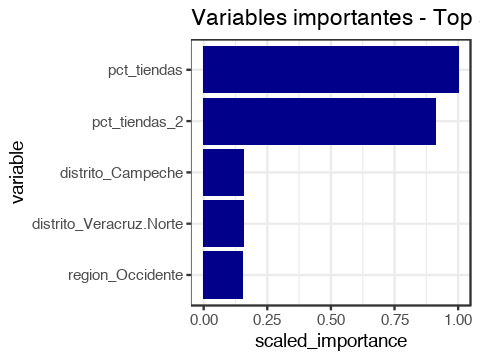

In [15]:
options(repr.plot.width=4, repr.plot.height=3)
var_imp <- h2o.varimp(model) %>% as.data.frame()
var_imp %>%
  head(5) %>%
  arrange(scaled_importance) %>%
  mutate(variable = fct_inorder(variable)) %>%
  ggplot() +
  geom_col(aes(x = variable, y = scaled_importance), fill = 'darkblue')  +
  theme_bw() +
  coord_flip()  +
  ggtitle('Variables importantes - Top 5')

## Efecto marginal - Pct de tiendas

  |======================================================================| 100%


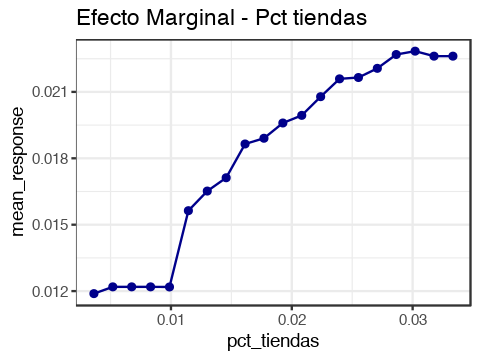

In [16]:
ef_mar <- h2o.partialPlot(model, train, cols = 'pct_tiendas', plot = FALSE) %>% as.data.frame()
ef_mar %>%
  ggplot() +
  geom_line(aes(x = pct_tiendas, y = mean_response), colour = 'darkblue') +
  geom_point(aes(x = pct_tiendas, y = mean_response), colour = 'darkblue') +
  theme_bw() +
  ggtitle('Efecto Marginal - Pct tiendas')


In [17]:
ef_mar <- h2o.partialPlot(model, train, cols = 'pct_tiendas_2', plot = FALSE) %>% as.data.frame()
ef_mar %>%
  ggplot() +
  geom_line(aes(x = pct_tiendas_2, y = mean_response), colour = 'darkblue') +
  geom_point(aes(x = pct_tiendas_2, y = mean_response), colour = 'darkblue') +
  theme_bw() +
  ggtitle('Efecto Marginal - Pct tiendas al cuadrado')

  |======================================================================| 100%


## Obervado vs Estimado - Train

  |======================================================================| 100%


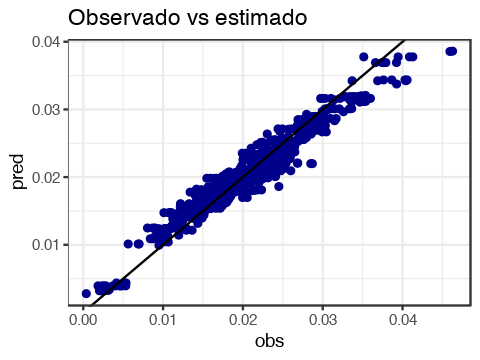

In [18]:
data.frame(obs = train$pct_plo %>% as.vector,
           pred = h2o.predict(model,train) %>% as.vector) %>%
  ggplot() +
  geom_point(aes(x = obs, y = pred), colour = 'darkblue') +
  theme_bw() +
  ggtitle('Observado vs estimado') +
  geom_abline(intercept = 0, slope = 1)

## Observado vs estimado para 2019

In [19]:
data %>%
  filter(anyo == '2019') %>%
  select(region,distrito,mes,pct_tiendas,pct_plo) -> data_2

In [20]:
# One hot encoding
data_2019 <- one_hot(data_2 %>% as.data.table)
data_2019 <-  data.frame(data_2019)

In [21]:
# Polinomial data
data_2019$pct_tiendas_2 <- data_2019$pct_tiendas^2
data_2019$pct_tiendas_2 <- data_2019$pct_tiendas^3

In [22]:
test <- as.h2o(data_2019)

  |======================================================================| 100%


In [23]:
options(repr.plot.width=5, repr.plot.height=3)

data.frame(obs = test$pct_plo %>% as.vector,
           pred = h2o.predict(model,test) %>% as.vector,
           region = data_2$region) %>%
  ggplot() +
  geom_point(aes(x = obs, y = pred, colour =  region)) +
  theme_bw() +
  ggtitle('Observado vs estimado - 2019') +
  geom_abline(intercept = 0, slope = 1) +
  scale_y_continuous(labels = scales::percent) +
  scale_x_continuous(labels = scales::percent)

  |======================================================================| 100%


## RMSE

RMSE para todos los datos y para 2019

In [24]:
rmse_todo <- h2o.rmse(h2o.performance(model, train))
rmse_2019 <- h2o.rmse(h2o.performance(model, test))

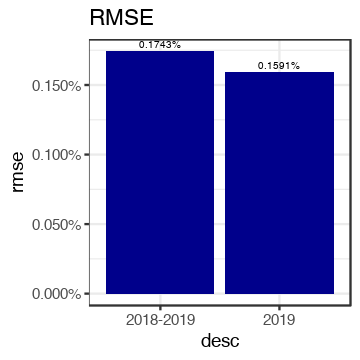

In [25]:
options(repr.plot.width=3, repr.plot.height=3)
data.frame(desc = c('2018-2019', '2019'),
           rmse = c(rmse_todo, rmse_2019)) %>%
 ggplot() +
 geom_col(aes(x = desc, y = rmse), fill = 'darkblue') +
 theme_bw() +
 ggtitle('RMSE') +
 scale_y_continuous(labels = scales::percent) +
 geom_text(aes(x = desc, y = rmse, label = scales::percent(rmse)), vjust = -0.5, size = 2)

## Se guarda obs vs estimado - 2019

In [26]:
info <- data.frame(data_2, pct_plo_estimado = h2o.predict(model,test) %>% as.vector)

setwd('/Users/darias/Desktop/Analisis_PLO')
write.csv(info, 'estimado_vs_real_pct_plo_distrito.csv', row.names = FALSE)

  |======================================================================| 100%
